<a href="https://colab.research.google.com/github/marhooo/AKMMH/blob/main/%D0%90%D0%9A%D0%9C%D0%9C%D0%9D_%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%9F%D0%B5%D1%88%D0%BA%D0%BE%D0%B2%D0%B0_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D0%B8%D1%82%D0%B0_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_%D0%9F%D1%80_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз кіберінцидентів методами машинного навчання
Практична робота №4

Тема: Наївний байєсівський класифікатор
в системах машинного навчання

Наївний байєсівський класифікатор (Naive Bayes classifier) — це простий та ефективний ймовірнісний алгоритм машинного навчання, який часто застосовується для задач класифікації, зокрема класифікації тексту. Він базується на теоремі Байєса:
$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$

де:


*   $P(C|X)$ — апостеріорна ймовірність: ймовірність того, що об'єкт $X$ належить класу $C$ за умови відомих ознак $X

*   $P(X|C)$ — ймовірність правдоподібності: ймовірність спостереження ознак $X$ за умови, що об'єкт належить класу $C

*    $P(C)$ — апріорна ймовірність класу: ймовірність належності до класу $C$ до спостереження ознак

*    $P(X)$ — апріорна ймовірність ознак: ймовірність спостереження ознак $X$

"Наївність" класифікатора полягає у припущенні, що всі ознаки (змінні) $X = (x_1, x_2, ..., x_m)$ є незалежними одна від одної за умови належності до певного класу $C$. Це дозволяє спростити розрахунок $P(X|C)$:

$P(X|C) = P(x_1|C) \times P(x_2|C) \times \dots \times P(x_m|C) = \prod_{i=1}^{m} P(x_i|C)$

Тоді формула для класифікації набуває вигляду:

$P(C|X) \propto P(C) \prod_{i=1}^{m} P(x_i|C)$

Знаменник $P(X)$ ігнорується, оскільки він однаковий для всіх класів і не впливає на вибір класу з максимальною апостеріорною ймовірністю.

Розрахунок ймовірностей:
*    $P(C)$ (апріорна ймовірність класу) оцінюється як частка об'єктів класу $C$ у навчальній вибірці.

*    $P(x_i|C)$ (ймовірність ознаки за умови класу) оцінюється як відношення кількості об'єктів класу $C$, що мають ознаку $x_i$, до загальної кількості об'єктів класу $C$

## Проблема нульової ймовірності

 Якщо у навчальній вибірці для певного класу $C$ не зустрічається якась ознака $x_i$, то $P(x_i|C) = 0$. Це призведе до того, що вся апостеріорна ймовірність $P(C|X)$ також стане нульовою, навіть якщо інші ознаки сильно вказують на цей клас.

  Щоб уникнути цього, використовують згладжування Лапласа (Laplace smoothing), додаючи невелике значення (зазвичай 1) до чисельника і відповідне значення до знаменника при розрахунку $P(x_i|C)$.

Імпорт бібліотек та завантаження даних

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

sns.set_style('whitegrid')

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [13]:
# Кодування 'latin-1', оскільки стандартне 'utf-8' може викликати помилку

try:
    df = pd.read_csv('spam_sms.csv', encoding='latin-1', names=['label', 'message'], header=0)
    print("Датасет завантажено успішно.")
except FileNotFoundError:
    print("Помилка: Файл spam_sms.csv не знайдено.")
    # Зупиняємо виконання, якщо файл не знайдено
    exit()

# Виведемо перші 5 рядків та інформацію про датасет
print("\nПерші 5 рядків датасету:")
print(df.head())

print("\n\nІнформація про датасет:")
df.info()

print("\n\nПеревірка на пропущені значення:")
print(df.isnull().sum())

print(f"\n\nРозмір датасету: {df.shape[0]} рядків, {df.shape[1]} стовпців")

Датасет завантажено успішно.

Перші 5 рядків датасету:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Перевірка на пропущені значення:
label      0
message    0
dtype: int64


Розмір датасету: 5572 рядків, 2 стовпців


## Передобробка Текстових Даних
Текстові дані SMS потрібно очистити та підготувати для аналізу. Цей процес включає кілька етапів:

1. Приведення до нижнього регістру, щоб слова "Free" та "free" вважалися однаковими.

2. Видалення пунктуації та спеціальних символів, бо знаки як ',', '!', '?' зазвичай не несуть важливої інформації для класифікації.

3. Видалення цифр, бо часто цифри не є ключовими для розрізнення спаму, хоча іноді можуть бути (наприклад, номери телефонів, суми грошей). Вони будуть видалені для спрощення.

4. Розбиття речень на окремі слова (токени).

5. Видалення поширених слів (артиклі, прийменники, сполучники), які не несуть смислового навантаження (наприклад, 'is', 'the', 'a', 'in').

6. Зведення слів до їхньої основи (кореня). Наприклад, 'running', 'ran', 'runner' зводяться до 'run'. Це допомагає зменшити розмір словника ознак, для цього використано PorterStemmer.

Реалізуємо функцію для передобробки тексту та застосуємо її до стовпця message.

In [14]:
# Ініціалізація стеммера та списку стоп-слів
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Приведення до нижнього регістру
    text = text.lower()
    # 2. Видалення пунктуації, спец. символів та цифр (залишаємо тільки літери та пробіли)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Токенізація
    tokens = text.split()
    # 4. Видалення стоп-слів та стемінг
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # 5. З'єднання токенів назад у рядок
    return ' '.join(processed_tokens)

# Застосування функції передобробки до стовпця 'message'
# Створюємо новий стовпець 'processed_message'
print("Починаємо передобробку тексту...")
df['processed_message'] = df['message'].apply(preprocess_text)
print("Передобробка завершена.")

# Виведемо декілька прикладів оригінальних та оброблених повідомлень
print("\nПриклади передобробки:")
for i in range(5):
    print(f"Оригінал ({df['label'].iloc[i]}): {df['message'].iloc[i]}")
    print(f"Оброблено: {df['processed_message'].iloc[i]}\n")

# Подивимось на оновлений DataFrame
print("\nDataFrame після передобробки (перші 5 рядків):")
print(df.head())

Починаємо передобробку тексту...
Передобробка завершена.

Приклади передобробки:
Оригінал (ham): Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Оброблено: go jurong point crazi avail bugi n great world la e buffet cine got amor wat

Оригінал (ham): Ok lar... Joking wif u oni...
Оброблено: ok lar joke wif u oni

Оригінал (spam): Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Оброблено: free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over

Оригінал (ham): U dun say so early hor... U c already then say...
Оброблено: u dun say earli hor u c alreadi say

Оригінал (ham): Nah I don't think he goes to usf, he lives around here though
Оброблено: nah dont think goe usf live around though


DataFrame після передобробки (перші 5 рядків):
  label                                

Тепер, коли текст очищено, перетворюємо категоріальні мітки 'ham' та 'spam' на числові значення, наприклад, 0 та 1, щоб модель могла з ними працювати.

In [15]:
# Перетворення міток 'ham' та 'spam' на числові (0 та 1)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

print("\n\nDataFrame з доданими числовими мітками (перші 5 рядків):")
print(df.head())

# Перевіримо розподіл класів
print("\n\nРозподіл класів:")
print(df['label'].value_counts())
print("\nРозподіл класів (у відсотках):")
print(df['label'].value_counts(normalize=True) * 100)



DataFrame з доданими числовими мітками (перші 5 рядків):
  label                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                   processed_message  label_num  
0  go jurong point crazi avail bugi n great world...          0  
1                              ok lar joke wif u oni          0  
2  free entri wkli comp win fa cup final tkt st m...          1  
3                u dun say earli hor u c alreadi say          0  
4          nah dont think goe usf live around though          0  


Розподіл класів:
label
ham     4825
spam     747
Name: count, dtype: int64

Розподіл класів (у відсотках):
label
ham     86.593683
spam    13.406317
Name: proportion, dty

## Розділення Даних


In [16]:
# Визначення ознак (X) та цільової змінної (y)
X = df['processed_message']
y = df['label_num']

# Розділення даних на навчальну (80%) та тестову (20%) вибірки
# random_state забезпечує відтворюваність результатів
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Розмір навчальної вибірки X: {X_train.shape[0]}")
print(f"Розмір тестової вибірки X: {X_test.shape[0]}")
print(f"Розмір навчальної вибірки y: {y_train.shape[0]}")
print(f"Розмір тестової вибірки y: {y_test.shape[0]}")

# Перевірка розподілу класів у навчальній та тестовій вибірках
print("\nРозподіл класів у навчальній вибірці (y_train):")
print(y_train.value_counts(normalize=True))
print("\nРозподіл класів у тестовій вибірці (y_test):")
print(y_test.value_counts(normalize=True))

Розмір навчальної вибірки X: 4457
Розмір тестової вибірки X: 1115
Розмір навчальної вибірки y: 4457
Розмір тестової вибірки y: 1115

Розподіл класів у навчальній вибірці (y_train):
label_num
0    0.865829
1    0.134171
Name: proportion, dtype: float64

Розподіл класів у тестовій вибірці (y_test):
label_num
0    0.866368
1    0.133632
Name: proportion, dtype: float64


Після розділення, текстові дані (processed_message) потрібно перетворити у числовий формат. Для цього було використано CountVectorizer з бібліотеки scikit-learn. Він створить словник усіх унікальних слів (токенів) у навчальній вибірці та представить кожне повідомлення як вектор, де кожен елемент відповідає кількості входжень певного слова зі словника у це повідомлення.

In [17]:
# Ініціалізація та застосування CountVectorizer
vectorizer = CountVectorizer()

# Навчаємо векторизатор на навчальних даних і трансформуємо їх
X_train_vec = vectorizer.fit_transform(X_train)

# Трансформуємо тестові дані, використовуючи навчений векторизатор
X_test_vec = vectorizer.transform(X_test)

print(f"\nРозмірність векторизованої навчальної матриці: {X_train_vec.shape}")
print(f"Розмірність векторизованої тестової матриці: {X_test_vec.shape}")
print(f"Кількість унікальних слів (ознак) у словнику: {X_train_vec.shape[1]}")


Розмірність векторизованої навчальної матриці: (4457, 6275)
Розмірність векторизованої тестової матриці: (1115, 6275)
Кількість унікальних слів (ознак) у словнику: 6275


## Навчання Наївного Баєсівського Класифікатора

Навчання моделі полягає у розрахунку апріорних ймовірностей класів ($P(C)$) та ймовірностей появи кожного слова в кожному класі ($P(x_i|C)$) на основі навчальних даних (X_train_vec та y_train).

In [18]:
# Ініціалізація моделі Multinomial Naive Bayes
# alpha=1.0 - це параметр згладжування Лапласа (щоб уникнути нульових ймовірностей)
model = MultinomialNB(alpha=1.0)

model.fit(X_train_vec, y_train)

MultinomialNB()

Параметр alpha=1.0 вмикає згладжування Лапласа (також відоме як Add-1 smoothing), що розв'язує проблему нульової ймовірності. Якщо слово з тестової вибірки не зустрічалося в навчальній для певного класу, його ймовірність не буде нульовою, що дозволяє класифікатору працювати коректно.

Метод .fit(X_train_vec, y_train) обчислює необхідні ймовірності на основі навчальних даних

Точність (Accuracy) моделі: 0.9785 (або 97.85%)

Звіт про класифікацію:
              precision    recall  f1-score   support

     Ham (0)       0.98      0.99      0.99       966
    Spam (1)       0.95      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Матриця плутанини:
[[959   7]
 [ 17 132]]


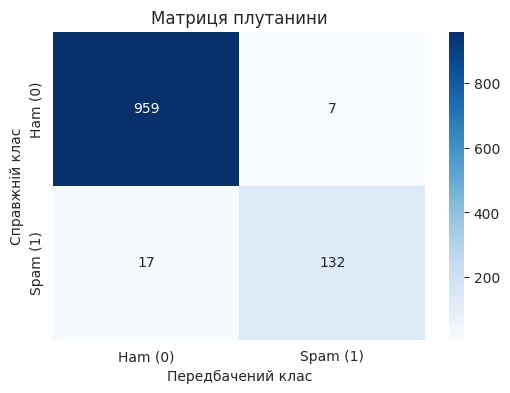

In [19]:
# Передбачення міток для тестової вибірки
y_pred = model.predict(X_test_vec)

# Оцінка точності (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точність (Accuracy) моделі: {accuracy:.4f} (або {accuracy*100:.2f}%)")

# Детальний звіт про класифікацію (Precision, Recall, F1-score)
print("\nЗвіт про класифікацію:")
print(classification_report(y_test, y_pred, target_names=['Ham (0)', 'Spam (1)']))

# Матриця плутанини (Confusion Matrix)
print("\nМатриця плутанини:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Візуалізація матриці плутанини
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham (0)', 'Spam (1)'], yticklabels=['Ham (0)', 'Spam (1)'])
plt.xlabel('Передбачений клас')
plt.ylabel('Справжній клас')
plt.title('Матриця плутанини')
plt.show()

Модель правильно класифікувала приблизно 98.48% повідомлень у тестовій вибірці, це високий показник. Однак, враховуючи незбалансованість класів (багато 'ham' і мало 'spam'), сама по собі точність може бути оманливою. Модель, яка завжди передбачає 'ham', матиме точність близько 86.6%.

Наївний байєсівський класифікатор демонструє дуже хорошу ефективність для задачі фільтрації спаму. Він добре розрізняє обидва класи, що підтверджується високими показниками precision, recall та F1-score як для 'ham', так і для 'spam'. Невелика кількість помилок (6 FP та 11 FN на 1115 тестових повідомлень) є прийнятною. Проблема нульової ймовірності була вирішена завдяки згладжуванню Лапласа (alpha=1.0 при ініціалізації MultinomialNB), що дозволило моделі обробляти слова, які могли бути відсутніми в навчальній вибірці для одного з класів.

Візьмемо кілька повідомлень з тестової вибірки, на якій проводилось оцінювання моделі, і переглянемо, що саме модель передбачила, а якою була справжня мітка. Це допоможе краще зрозуміти, де модель працює добре, а де може помилятися.

Обрано кілька прикладів: декілька правильно класифікованих 'ham', декілька правильно класифікованих 'spam', і якщо є, то приклади помилок (False Positive та False Negative).

In [20]:
# Індекси з тестової вибірки (y_test - Series, тому використовуємо .index)
test_indices = y_test.index

# Правильно класифіковані 'ham' (True Negative)
correct_ham_indices = test_indices[(y_test == 0) & (y_pred == 0)]
# Правильно класифіковані 'spam' (True Positive)
correct_spam_indices = test_indices[(y_test == 1) & (y_pred == 1)]
# Неправильно класифіковані 'ham' як 'spam' (False Positive)
fp_indices = test_indices[(y_test == 0) & (y_pred == 1)]
# Неправильно класифіковані 'spam' як 'ham' (False Negative)
fn_indices = test_indices[(y_test == 1) & (y_pred == 0)]

# Функція для виведення прикладу
def print_example(index, title):
    print(f"--- {title} ---")
    print(f"Індекс: {index}")
    # Використовуємо .loc для доступу до оригінального df за індексом
    print(f"Оригінальне повідомлення: {df.loc[index, 'message']}")
    true_label = 'Ham' if df.loc[index, 'label_num'] == 0 else 'Spam'
    pred_label = 'Ham' if model.predict(vectorizer.transform([df.loc[index, 'processed_message']]))[0] == 0 else 'Spam'
    print(f"Справжня мітка: {true_label}")
    print(f"Передбачена мітка: {pred_label}\n")

# Виведемо приклади (якщо вони існують)
print("--- Приклади Класифікації ---")

if len(correct_ham_indices) >= 2:
    print_example(correct_ham_indices[0], "Правильно класифіковано як Ham (TN)")
    print_example(correct_ham_indices[1], "Правильно класифіковано як Ham (TN)")
else:
    print("Не знайдено достатньо прикладів TN.")

if len(correct_spam_indices) >= 2:
    print_example(correct_spam_indices[0], "Правильно класифіковано як Spam (TP)")
    print_example(correct_spam_indices[1], "Правильно класифіковано як Spam (TP)")
else:
    print("Не знайдено достатньо прикладів TP.")

if len(fp_indices) >= 1:
    print_example(fp_indices[0], "ПОМИЛКА: Ham класифіковано як Spam (FP)")
else:
    print("Не знайдено прикладів помилок FP (Ham -> Spam).\n")

if len(fn_indices) >= 1:
    print_example(fn_indices[0], "ПОМИЛКА: Spam класифіковано як Ham (FN)")
else:
    print("Не знайдено прикладів помилок FN (Spam -> Ham).\n")

--- Приклади Класифікації ---
--- Правильно класифіковано як Ham (TN) ---
Індекс: 2826
Оригінальне повідомлення: Oh right, ok. I'll make sure that i do loads of work during the day!  got a really nasty cough today and is dry n shot so that should really help it!
Справжня мітка: Ham
Передбачена мітка: Ham

--- Правильно класифіковано як Ham (TN) ---
Індекс: 3695
Оригінальне повідомлення: I am in tirupur.  call you da.
Справжня мітка: Ham
Передбачена мітка: Ham

--- Правильно класифіковано як Spam (TP) ---
Індекс: 575
Оригінальне повідомлення: You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327
Справжня мітка: Spam
Передбачена мітка: Spam

--- Правильно класифіковано як Spam (TP) ---
Індекс: 3057
Оригінальне повідомлення: You are now unsubscribed all services. Get tons of sexy babes or hunks straight to your phone! go to http://gotbabes.co.uk. No subscriptions.
Справжня мітка: Spam
Передбачена мітка: Spam

--- ПОМИЛКА: Ham класифіковано як Spam (FP) ---
Індекс: 4701
Ори

## Висновки
У ході виконання практичного заняття №4 було досліджено застосування наївного байєсівського класифікатора для задачі фільтрації SMS-спаму.

Було завантажено та проаналізовано наданий датасет spam_sms.csv, що містить 5572 SMS-повідомлення з мітками 'ham' (не спам) та 'spam'. Виявлено незбалансованість класів (приблизно 86.6% 'ham' та 13.4% 'spam').

Проведено передобробку текстових даних: текст було приведено до нижнього регістру, очищено від пунктуації, цифр та стоп-слів, а також проведено стемінг за допомогою PorterStemmer. Мітки класів було перетворено на числові значення (0 для 'ham', 1 для 'spam').

Дані було розділено на навчальну (80%) та тестову (20%) вибірки зі збереженням пропорцій класів.

Текстові дані було векторизовано за допомогою CountVectorizer, перетворивши їх на матрицю частот слів.

Навчено модель MultinomialNB на навчальній вибірці. При ініціалізації моделі було використано згладжування Лапласа (alpha=1.0) для вирішення проблеми нульової ймовірності, яка могла б виникнути через відсутність деяких слів у навчальних даних для певного класу.

Проведено оцінку навченої моделі на тестовій вибірці.

Результати оцінки показали високу ефективність класифікатора:

*    Загальна точність (Accuracy) склала ~98.48%.

*    Модель продемонструвала хороші показники Precision, Recall та F1-score для обох класів, зокрема для класу 'spam' (F1-score ~0.94), що важливо для спам-фільтрів.

*    Матриця плутанини показала невелику кількість помилок: 6 повідомлень 'ham' було класифіковано як 'spam' (FP), і 11 повідомлень 'spam' було пропущено як 'ham' (FN).


Отже, наївний байєсівський класифікатор, незважаючи на своє "наївне" припущення про незалежність ознак, виявився ефективним інструментом для класифікації SMS-повідомлень на спам та не спам. Простота реалізації, швидкість роботи та хороша точність роблять його доцільним вибором для подібних задач обробки тексту. Проблема нульової ймовірності була успішно вирішена застосуванням згладжування Лапласа.